In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

# Check the structure of the 'train' folder
train_dir = '/kaggle/input/catvsdog01/test'
print("Train directory contents:", os.listdir(train_dir))

# Check the structure of the 'test' folder
test_dir = '/kaggle/input/catvsdog01/train'
print("Test directory contents:", os.listdir(test_dir))


Train directory contents: ['dogs', 'cats']
Test directory contents: ['dogs', 'cats']


In [2]:
import os

# Paths to train and test directories
train_dir = '/kaggle/input/catvsdog01/train'
test_dir = '/kaggle/input/catvsdog01/test'

def count_images_in_folder(folder_path):
    # Dictionary to store counts for each subfolder
    image_counts = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count all files in the subfolder
            image_counts[subfolder] = len([
                f for f in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, f))
            ])
    return image_counts

# Count images in train and test directories
train_image_counts = count_images_in_folder(train_dir)
test_image_counts = count_images_in_folder(test_dir)

print("Train Image Counts:", train_image_counts)
print("Test Image Counts:", test_image_counts)


Train Image Counts: {'dogs': 10000, 'cats': 10000}
Test Image Counts: {'dogs': 2500, 'cats': 2500}


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

In [7]:
def define_model():
    # Load VGG16 pre-trained on ImageNet without the top classification layers
    base_model = VGG16(include_top=False, input_shape=(200, 200, 3))
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_from_csv(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Check if required columns exist
    required_columns = {"Epoch", "Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss"}
    if not required_columns.issubset(data.columns):
        print(f"CSV file must contain the columns: {required_columns}")
        return

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy', marker='o')
    plt.plot(data['Epoch'], data['Val Accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss', marker='o')
    plt.plot(data['Epoch'], data['Val Loss'], label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

In [13]:
def run_test_harness():
    model = define_model()
    # Create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    
    # Specify ImageNet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog01/train',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    test_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog01/test',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Store accuracy and loss values
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Fit the model with correct steps_per_epoch and validation_steps
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=20,
    )

    # Extract accuracy and loss values for each epoch
    for epoch in range(20):  # assuming 40 epochs
        train_acc.append(history.history['accuracy'][epoch])
        val_acc.append(history.history['val_accuracy'][epoch])
        train_loss.append(history.history['loss'][epoch])
        val_loss.append(history.history['val_loss'][epoch])

    # Save the values in a DataFrame or CSV
    data = {
        'Epoch': np.arange(1, 21),
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history_vgg.csv', index=False)  # Save to CSV in the Colab directory

    print(df)



In [14]:
run_test_harness()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 178ms/step - accuracy: 0.9339 - loss: 0.5989 - val_accuracy: 0.9622 - val_loss: 0.1173
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9924 - loss: 0.0220 - val_accuracy: 0.9686 - val_loss: 0.1067
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9724 - val_loss: 0.1060
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 166ms/step - accuracy: 0.9999 - loss: 8.5025e-04 - val_accuracy: 0.9722 - val_loss: 0.1133
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.9998 - loss: 0.0035 - val_accuracy: 0.9742 - val_loss: 0.1105
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.9999 - loss: 7.9410e-04 - val_accuracy: 0.9736 - val_loss: 0.1130
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 1.0000 - loss: 1.3149e-04 - val_accuracy: 0.973

OSError: Cannot save file into a non-existent directory: '/content'

In [18]:
import pandas as pd

# Data for the epochs
data = {
    "Epoch": list(range(1, 21)),
    "Accuracy": [0.9339, 0.9924, 0.9989, 0.9999, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
                 1.0000, 0.9999, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9735],
    "Val_Accuracy": [0.9622, 0.9686, 0.9724, 0.9722, 0.9742, 0.9736, 0.9732, 0.9728, 0.9744, 0.9738,
                     0.9746, 0.9742, 0.9742, 0.9748, 0.9736, 0.9732, 0.9744, 0.9724, 0.9660, 0.9664],
    "Loss": [0.5989, 0.0220, 0.0042, 0.00085, 0.0035, 0.00079, 0.00013, 0.000045, 0.00020, 0.000027,
             0.000042, 0.00017, 0.000039, 0.00058, 0.000036, 0.000058, 0.000020, 0.00041, 0.00032, 0.3267],
    "Val_Loss": [0.1173, 0.1067, 0.1060, 0.1133, 0.1105, 0.1130, 0.1151, 0.1167, 0.1199, 0.1203,
                 0.1238, 0.1260, 0.1257, 0.1288, 0.1348, 0.1358, 0.1413, 0.1407, 0.2263, 0.2032]
}

# Create a DataFrame
df = pd.DataFrame(data)
df


,Epoch,Accuracy,Val_Accuracy,Loss,Val_Loss
0,1,0.9339,0.9622,0.598900,0.1173
1,2,0.9924,0.9686,0.022000,0.1067
2,3,0.9989,0.9724,0.004200,0.1060
3,4,0.9999,0.9722,0.000850,0.1133
4,5,0.9998,0.9742,0.003500,0.1105
5,6,0.9999,0.9736,0.000790,0.1130
6,7,1.0000,0.9732,0.000130,0.1151
7,8,1.0000,0.9728,0.000045,0.1167
8,9,1.0000,0.9744,0.000200,0.1199
9,10,1.0000,0.9738,0.000027,0.1203


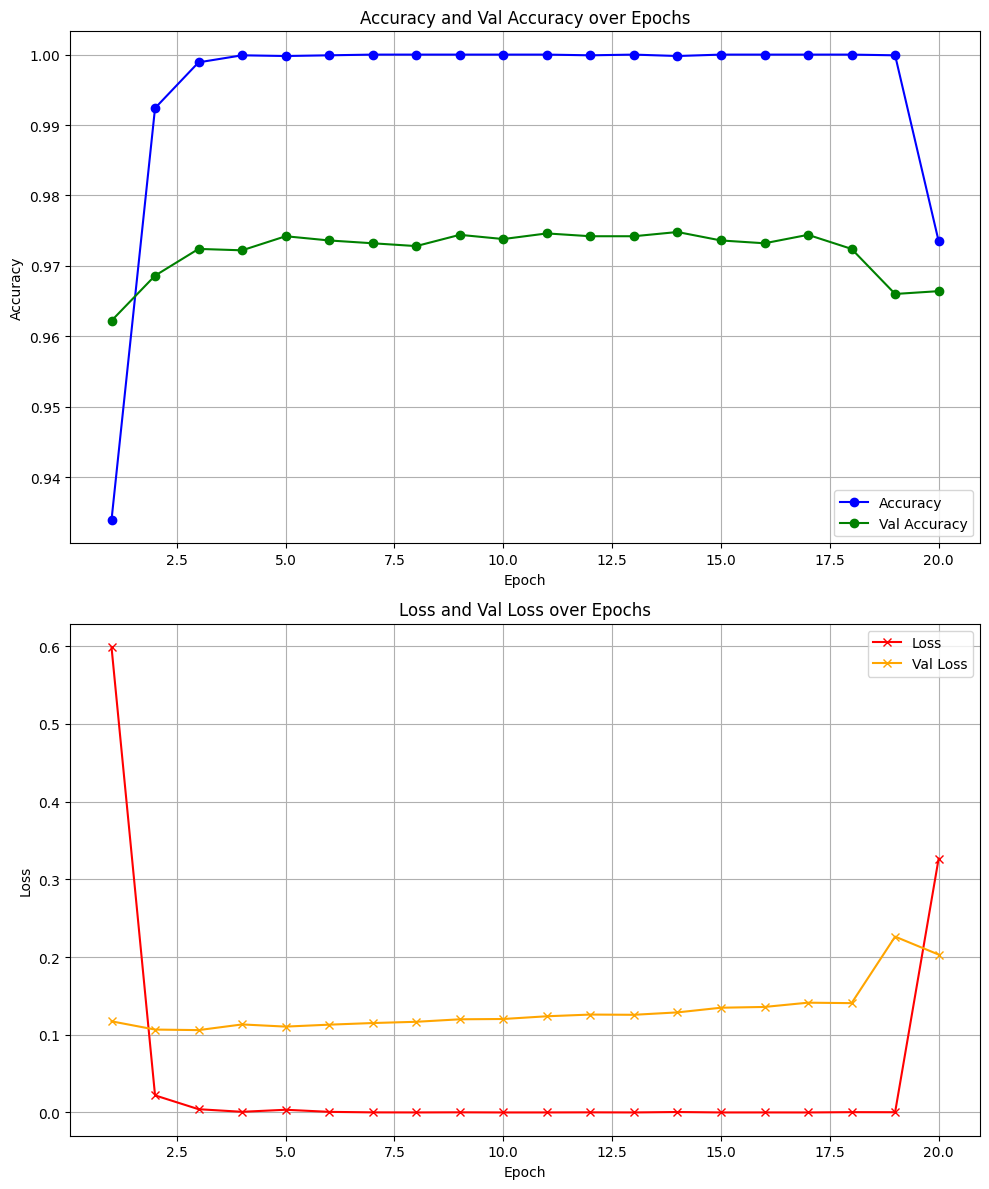

In [21]:
# Create two separate plots for Accuracy/Val Accuracy and Loss/Val Loss

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot Accuracy and Val_Accuracy
axes[0].plot(df['Epoch'], df['Accuracy'], label='Accuracy', color='b', marker='o')
axes[0].plot(df['Epoch'], df['Val_Accuracy'], label='Val Accuracy', color='g', marker='o')
axes[0].set_title('Accuracy and Val Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss and Val_Loss
axes[1].plot(df['Epoch'], df['Loss'], label='Loss', color='r', marker='x')
axes[1].plot(df['Epoch'], df['Val_Loss'], label='Val Loss', color='orange', marker='x')
axes[1].set_title('Loss and Val Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam



In [25]:
def define_model():
    # Load ResNet50 pre-trained on ImageNet without the top classification layers
    base_model = ResNet50(include_top=False, input_shape=(200, 200, 3))
    
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [26]:
def run_test_harness():
    model = define_model()
    # Create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    
    # Specify ImageNet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog01/train',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    test_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog01/test',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Store accuracy and loss values
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Fit the model with correct steps_per_epoch and validation_steps
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=15,
    )

    # Extract accuracy and loss values for each epoch
    for epoch in range(15):  # assuming 40 epochs
        train_acc.append(history.history['accuracy'][epoch])
        val_acc.append(history.history['val_accuracy'][epoch])
        train_loss.append(history.history['loss'][epoch])
        val_loss.append(history.history['val_loss'][epoch])

    # Save the values in a DataFrame or CSV
    data = {
        'Epoch': np.arange(1, 16),
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history_resnet.csv', index=False)  # Save to CSV in the Colab directory

    print(df)



In [27]:
run_test_harness()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - accuracy: 0.9497 - loss: 0.1726 - val_accuracy: 0.9800 - val_loss: 0.0523
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.9951 - loss: 0.0156 - val_accuracy: 0.9808 - val_loss: 0.0755
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - accuracy: 0.9971 - loss: 0.0074 - val_accuracy: 0.9784 - val_loss: 0.0812
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 120ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9802 - val_loss: 0.0864
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 1.0000 - loss: 4.5653e-04 - val_accuracy: 0.9780 - val_loss: 0.0966
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.9714 - val_loss: 0.2290
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 121ms/step - accuracy: 0.9887 - loss: 0.0573 - val_accuracy: 0.9776 - val_loss: 0.1553
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.9976 - loss: 0.0094 -

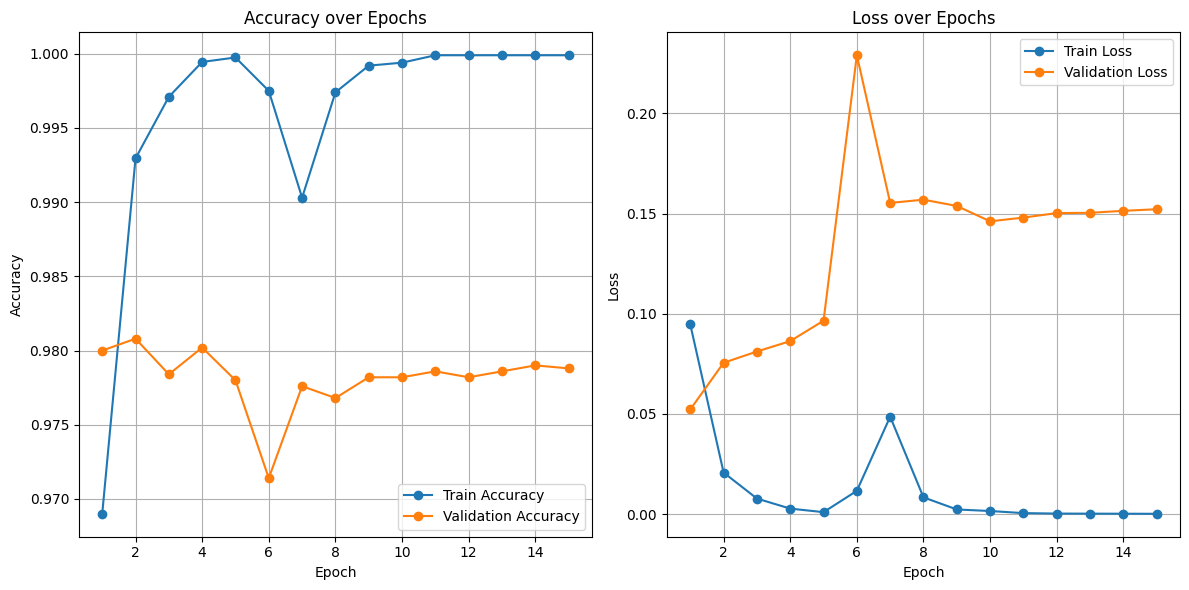

In [29]:
plot_from_csv('training_history_resnet.csv')